# County level agvar analysis: Figure 2

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import scipy.stats as ss
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['pdf.fonttype'] = 42

cm_data = np.loadtxt("../plotting_tools/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

In [2]:
# Import plotting shapefiles
county_shp = gp.read_file('../plotting_tools/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)
county_shp['area'] = county_shp['geometry'].apply(lambda x: x.area)
county_shp = county_shp.query('area > 10e3')

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['GEOID'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35', '32'] # Western half of CONUS
county_shp_plot = county_shp_plot.drop(StateDrop)

states = gp.read_file('../plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../plotting_tools/coast_contig_plot.shp')

In [2]:
# Get both ensembles
from combine import combine_nex_agvar, combine_cmip_agvar

nex_all = combine_nex_agvar()

cmip_all = combine_cmip_agvar()

### Fit bandwidths for each county for each agvar

In [8]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [52]:
%%time
#############################
#### WARNING: this took 6hrs 14mins to run on my local machine. Importing the results (next cell) will be much faster
############################
NEXres = []
CMIPres = []
for geoid in nex_all.index.unique(level = 'GEOID'):
    nexres = {}
    nexres.update({'GEOID' : geoid})
    cmipres = {}
    cmipres.update({'GEOID' : geoid})
    for agvar in ['gdd','egdd','prcp']:
        # Ensembles
        NEXens = nex_all.loc[agvar,geoid].drop(columns=['GMFD']).to_numpy().flatten()
        CMIPens = cmip_all.loc[agvar,geoid].drop(columns=['GMFD']).to_numpy().flatten()
        # Obs
        GMFDobs = nex_all.loc[agvar,geoid].filter(['GMFD']).to_numpy()
        # Find best bandswidth
        if silverman(NEXens) == 0.0:
            nexres.update({agvar+'_bw' : 0.0})
        else:
            nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens), 2*silverman(NEXens), 20)})
            nexgrid.fit(NEXens[:, None])
            nexres.update({agvar+'_bw' : nexgrid.best_params_['bandwidth']})
        if silverman(CMIPens) == 0.0:
            cmipres.update({agvar+'_bw' : 0.0})
        else:
            cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens), 2*silverman(CMIPens), 20)})
            cmipgrid.fit(CMIPens[:, None])
            cmipres.update({agvar+'_bw' : cmipgrid.best_params_['bandwidth']})
    # Append
    NEXres.append(nexres)
    CMIPres.append(cmipres)
    
# Store results
NEX_res = pd.DataFrame.from_dict(NEXres)
NEX_res.to_csv('./bandwidths/nex_agvar_bws_cont.csv', index=False)

CMIP_res = pd.DataFrame.from_dict(CMIPres)
CMIP_res.to_csv('./bandwidths/cmip_agvar_bws_cont.csv', index=False)

CPU times: user 6h 14min, sys: 1min 50s, total: 6h 15min 50s
Wall time: 6h 24min 55s


In [24]:
# Read results
NEX_res = pd.read_csv('./bandwidths/nex_agvar_bws.csv')
NEX_res['GEOID'] = NEX_res['GEOID'].astype(str).str.zfill(5)
NEX_res = NEX_res.set_index(['GEOID']).sort_index()

CMIP_res = pd.read_csv('./bandwidths/cmip_agvar_bws.csv')
CMIP_res['GEOID'] = CMIP_res['GEOID'].astype(str).str.zfill(5)
CMIP_res = CMIP_res.set_index(['GEOID']).sort_index()

### Calculate tail probabilities for each test statistic, for each county, for each ag variable

In [123]:
%%time
#############################
#### WARNING: this took ~8hrs to run on my local machine for each ag variable. Importing the results (next cell) will be much faster
############################
############################
# Select ag variable
agvars = ['gdd', 'egdd', 'prcp']
agvar = agvars[1]
############################
# Results dict
NEXtail = []
CMIPtail = []
# Loop over each county
for geoid in nex_all.index.unique(level = 'GEOID')[:10]:
    # Ensembles
    NEXens = nex_all.loc[agvar,geoid].drop(columns=['GMFD']).to_numpy().flatten()
    CMIPens = cmip_all.loc[agvar,geoid].drop(columns=['GMFD']).to_numpy().flatten()
    # Obs
    GMFDobs = nex_all.loc[agvar,geoid].filter(['GMFD']).to_numpy()
    gmfd_sd = np.std(GMFDobs)
    gmfd_mad = ss.median_absolute_deviation(GMFDobs)
    gmfd_min = GMFDobs.min()
    # NEX
    if NEX_res.loc[geoid][agvar+'_bw'] > 0.0:
        # KDE
        nex_kde_skl = KernelDensity(bandwidth=NEX_res.loc[geoid][agvar+'_bw'])
        nex_kde_skl.fit(NEXens[:, None])
        # Samples
        nex_sample = np.array([nex_kde_skl.sample(n_samples=len(GMFDobs)).flatten() for i in range(10000)])
        # SD
        nex_sd_sample = np.array([np.std(dat) for dat in nex_sample])
        nex_sd_ecdf = ECDF(nex_sd_sample)
        # MAD
        nex_mad_sample = np.array([ss.median_absolute_deviation(dat) for dat in nex_sample])
        nex_mad_ecdf = ECDF(nex_mad_sample)
        # Update
        NEXtail.append({'GEOID': geoid,
                        'gmfd_sd': 1.-nex_sd_ecdf(gmfd_sd),
                        'gmfd_mad': 1.-nex_mad_ecdf(gmfd_mad)[0]})
    
    ### CMIP
    # KDE
    cmip_kde_skl = KernelDensity(bandwidth=CMIP_res.loc[geoid][agvar+'_bw'])
    cmip_kde_skl.fit(CMIPens[:, None])
    # Samples
    cmip_sample = np.array([cmip_kde_skl.sample(n_samples=len(GMFDobs)).flatten() for i in range(10000)])
    # SD
    cmip_sd_sample = np.array([np.std(dat) for dat in cmip_sample])
    cmip_sd_ecdf = ECDF(cmip_sd_sample)
    # MAD
    cmip_mad_sample = np.array([ss.median_absolute_deviation(dat) for dat in cmip_sample])
    cmip_mad_ecdf = ECDF(cmip_mad_sample)
    # Update
    CMIPtail.append({'GEOID': geoid,
                     'gmfd_sd': 1.-cmip_sd_ecdf(gmfd_sd),
                     'gmfd_mad': 1.-cmip_mad_ecdf(gmfd_mad)[0]
                    })
    
# # Store results
# NEX_tail = pd.DataFrame.from_dict(NEXtail)
# NEX_tail.to_csv('./output/nex_'+agvar+'_pvals_56-05.csv', index=False)

# CMIP_tail = pd.DataFrame.from_dict(CMIPtail)
# CMIP_tail.to_csv('./output/cmip_'+agvar+'_pvals_56-05.csv', index=False)

CPU times: user 53.6 s, sys: 547 ms, total: 54.1 s
Wall time: 1min


In [128]:
len(nex_all.index.unique(level = 'GEOID'))/10*60/60/60

5.180000000000001

In [3]:
# Read results
nex_gdd = pd.read_csv('./output/nex_gdd_pvals_60-05.csv')
nex_gdd['GEOID'] = nex_gdd['GEOID'].astype(str).str.zfill(5)

nex_egdd = pd.read_csv('./output/nex_egdd_pvals_60-05.csv')
nex_egdd['GEOID'] = nex_egdd['GEOID'].astype(str).str.zfill(5)

nex_prcp = pd.read_csv('./output/nex_prcp_pvals_60-05.csv')
nex_prcp['GEOID'] = nex_prcp['GEOID'].astype(str).str.zfill(5)

cmip_gdd = pd.read_csv('./output/cmip_gdd_pvals_60-05.csv')
cmip_gdd['GEOID'] = cmip_gdd['GEOID'].astype(str).str.zfill(5)

cmip_egdd = pd.read_csv('./output/cmip_egdd_pvals_60-05.csv')
cmip_egdd['GEOID'] = cmip_egdd['GEOID'].astype(str).str.zfill(5)

cmip_prcp = pd.read_csv('./output/cmip_prcp_pvals_60-05.csv')
cmip_prcp['GEOID'] = cmip_prcp['GEOID'].astype(str).str.zfill(5)

## Figure 2

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


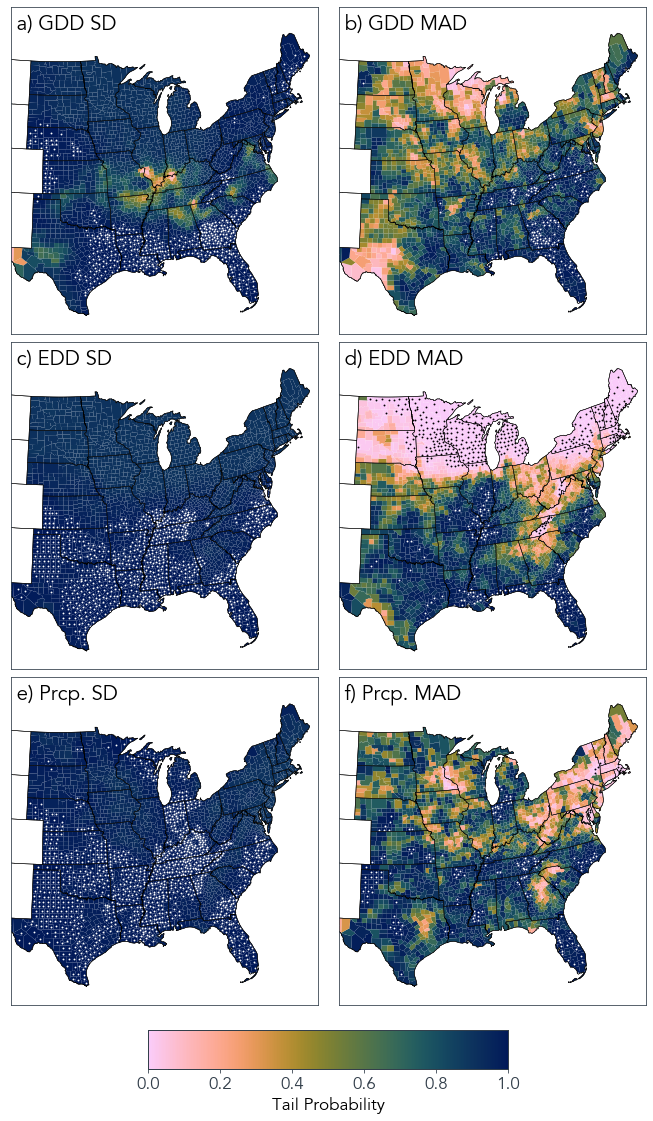

In [8]:
# All
fig = plt.figure(figsize=(10, 18))
gs = gridspec.GridSpec(nrows = 3, ncols = 2, wspace=0.025, hspace=0.025)
gs.update(top = 0.95, bottom = 0.18, left = 0.05, right = 0.95)
vmin, vmax = 0., 1.
cax = fig.add_axes([0.25, 0.13, 0.5, 0.03])
plt.rcParams['font.size'] = 17

####### GDD
# SD
ax = plt.subplot(gs[0])
model = 'gmfd_sd'
vmin = 0.
vmax = 1.

data = nex_gdd.copy()
data.set_index('GEOID', inplace=True)

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_sd <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_sd >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=3, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=3, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title(' a) GDD SD', loc = 'left', pad = -22)
ax.set_ylim([-2300000,1000000])
ax.set_xlim([-500000,2600000])

# MAD
ax = plt.subplot(gs[1])
model = 'gmfd_mad'
vmin = 0.
vmax = 1.

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_mad <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_mad >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=3, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=3, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title(' b) GDD MAD', loc = 'left', pad = -22)
ax.set_ylim([-2300000,1000000])
ax.set_xlim([-500000,2600000])

####### eGDD
# SD
ax = plt.subplot(gs[2])
model = 'gmfd_sd'
vmin = 0.
vmax = 1.

data = nex_egdd.copy()
data.set_index('GEOID', inplace=True)

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_sd <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_sd >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=3, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=3, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title(' c) EDD SD', loc = 'left', pad = -22)
ax.set_ylim([-2300000,1000000])
ax.set_xlim([-500000,2600000])

# MAD
ax = plt.subplot(gs[3])
model = 'gmfd_mad'
vmin = 0.
vmax = 1.

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_mad <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_mad >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=3, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=3, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title(' d) EDD MAD', loc = 'left', pad = -22)
ax.set_ylim([-2300000,1000000])
ax.set_xlim([-500000,2600000])

####### PRCP
# SD
ax = plt.subplot(gs[4])
model = 'gmfd_sd'
vmin = 0.
vmax = 1.

data = nex_prcp.copy()
data.set_index('GEOID', inplace=True)

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_sd <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_sd >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=3, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=3, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title(' e) Prcp. SD', loc = 'left', pad = -22)
ax.set_ylim([-2300000,1000000])
ax.set_xlim([-500000,2600000])

# MAD
ax = plt.subplot(gs[5])
model = 'gmfd_mad'
vmin = 0.
vmax = 1.

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_mad <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_mad >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=3, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=3, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title(' f) Prcp. MAD', loc = 'left', pad = -22)
ax.set_ylim([-2300000,1000000])
ax.set_xlim([-500000,2600000])


# Colorbar
sm = plt.cm.ScalarMappable(cmap=batlow_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation = 'horizontal', label = 'Tail Probability')


# Show
plt.show()